In [12]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt
from utils import *
from models import *


# Fitting a quadratic spline to 3 points

In [13]:
import numpy as np

# Constraints
x0 = 0
y0 = 3
d0 = 2

x1 = 1
y1 = 5

x2 = 3
y2 = 4
d2 = -100

def plot_constraints():
    d0grid = np.linspace(-0.5,0,100)
    plt.plot(x0+d0grid,y0+d0*d0grid,color="r")
    d2grid = np.linspace(0,0.07,100)
    plt.plot(x2+d2grid,y2+d2*d2grid,color="r")
    plt.scatter([x0, x1, x2], [y0, y1, y2], color="r")
    plt.show()

## Explicitly allow for error $e$ in $y1$, so n=k exact solution

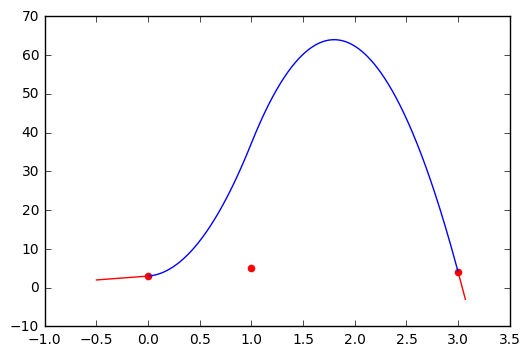

In [14]:
# Explicitly allow for error e in y1
b = np.array([y0, d0, y1, y2, d2, y1, 0])
A = np.array([
    [x0**2, x0, 1,  0,     0,  0,  0],
    [2*x0,  1,  0,  0,     0,  0,  0],
    [x1**2, x1, 1,  0,     0,  0, -1],
    [0,     0,  0,  x2**2, x2, 1,  0],
    [0,     0,  0,  2*x2,  1,  0,  0],
    [0,     0,  0,  x1**2, x1, 1, -1],
    [2*x1,  1,  0, -2*x1, -1,  0,  0]
])

x = np.linalg.solve(A, b)
[a1, b1, c1, a2, b2, c2, e] = list(x)

xgrid1 = np.linspace(x0, x1, 1000)
xgrid2 = np.linspace(x1, x2, 1000)
ygrid1 = a1 * xgrid1**2 + b1 * xgrid1 + c1
ygrid2 = a2 * xgrid2**2 + b2 * xgrid2 + c2

plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([ygrid1, ygrid2]))
plot_constraints()
plt.show()

## No longer allow for error, so n > k, least squares best fit (unweighted)

In [15]:
# Remove error, find best fit by least squares
W = np.diag(weights)
Aprime = A[:,:-1]
xprime = np.linalg.lstsq(Aprime, b)[0]

[a1, b1, c1, a2, b2, c2] = list(xprime)

ygrid1 = a1 * xgrid1**2 + b1 * xgrid1 + c1
ygrid2 = a2 * xgrid2**2 + b2 * xgrid2 + c2

plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([ygrid1, ygrid2]))
plot_constraints()
plt.show()

NameError: name 'weights' is not defined

## Use weighted least squares to prioritise intermediate points & derivatives

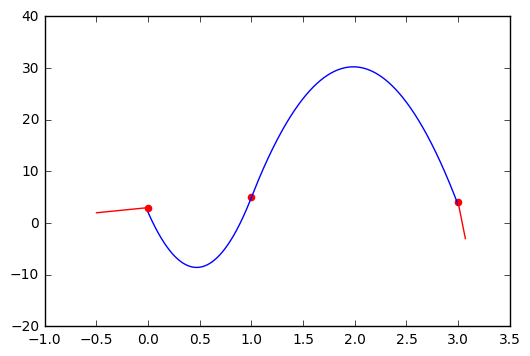

In [16]:
# Use weights to prioritise fit
W = np.diag([10, 1, 100, 10, 1, 100, 1000])
Aprime = A[:,:-1]
xprime = np.linalg.lstsq(np.matmul(W,Aprime), np.matmul(W,b))[0]

[a1, b1, c1, a2, b2, c2] = list(xprime)

ygrid1 = a1 * xgrid1**2 + b1 * xgrid1 + c1
ygrid2 = a2 * xgrid2**2 + b2 * xgrid2 + c2

plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([ygrid1, ygrid2]))
plot_constraints()
plt.show()

## Use substitution to enforce y0 fit and fit rest by least squares

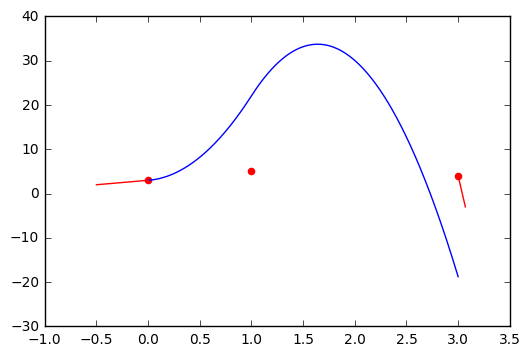

In [17]:
# Fix y0 by substitution
W = np.diag([100, 1000, 10, 10, 20, 1000])
bpp = np.array([d0, -y0, y2, d2, y1, 0])
App = np.array([
    [2*x0,  1,  0,     0,  0],
    [x1**2-x0**2, x1-x0,  -x1**2,     -x1,  -1],
    [0,     0,  x2**2, x2, 1],
    [0,     0,  2*x2,  1,  0],
    [0,     0,  x1**2, x1, 1],
    [2*x1,  1, -2*x1, -1,  0]
])
xpp = np.linalg.lstsq(np.matmul(W,App), np.matmul(W,bpp))[0]

[a1, b1, a2, b2, c2] = list(xpp)
c1 = y0 - a1*x0**2 - b1*x0

ygrid1 = a1 * xgrid1**2 + b1 * xgrid1 + c1
ygrid2 = a2 * xgrid2**2 + b2 * xgrid2 + c2

plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([ygrid1, ygrid2]))
plot_constraints()
plt.show()

## Try to minimise second derivative squared sum

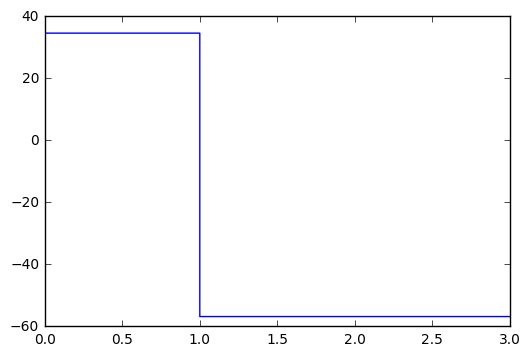

In [18]:
d2grid1 = 2 * a1 * xgrid1 ** 0
d2grid2 = 2 * a2 * xgrid2 ** 0
plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([d2grid1, d2grid2]))
plt.show()

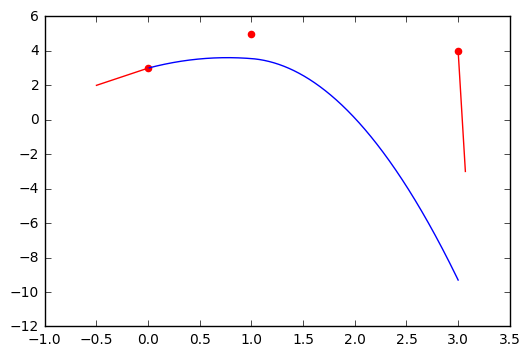

In [19]:
# Fix y0 by substitution
W = np.diag([100, 1000, 10, 10, 20, 1000, 100, 100])
bpp = np.array([d0, -y0, y2, d2, y1, 0, 0 ,0])
App = np.array([
    [2*x0,  1,  0,     0,  0],
    [x1**2-x0**2, x1-x0,  -x1**2,     -x1,  -1],
    [0,     0,  x2**2, x2, 1],
    [0,     0,  2*x2,  1,  0],
    [0,     0,  x1**2, x1, 1],
    [2*x1,  1, -2*x1, -1,  0],
    [1,     0,     0,  0,  0], # a1 penalty
    [0,     0,     1,  0,  0]  # a2 penalty
])
xpp = np.linalg.lstsq(np.matmul(W,App), np.matmul(W,bpp))[0]

[a1, b1, a2, b2, c2] = list(xpp)
c1 = y0 - a1*x0**2 - b1*x0

ygrid1 = a1 * xgrid1**2 + b1 * xgrid1 + c1
ygrid2 = a2 * xgrid2**2 + b2 * xgrid2 + c2

plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([ygrid1, ygrid2]))
plot_constraints()
plt.show()

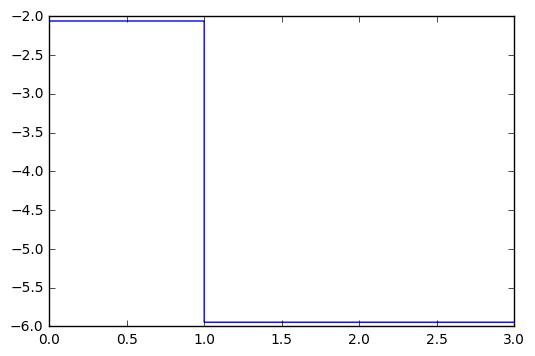

In [20]:
d2grid1 = 2 * a1 * xgrid1 ** 0
d2grid2 = 2 * a2 * xgrid2 ** 0
plt.plot(np.hstack([xgrid1, xgrid2]), np.hstack([d2grid1, d2grid2]))
plt.show()

Strategy:
- $L(p)$ is a quartic
- $Q(p)$ is a cubic
- $F(x)$ is like a cubic
- $f(x)$ is like a quadratic
- $f'(x)$ is linear
- $f''(x)$ is constant

So fit spline with
- endpoints must fit
- endpoint derivatives must fit / or high weight
- midpoints derivatives etc must match
- midpoint positions must match
- midpoint posititions close to fit

subject to minimise sum(d4^2)

In the base spline we have
- [1] equals y0 [1]
- [(P-2)(K+1)] for each interior point (P-2)
  - [1] equals y [1]
  - [1] matches y[0] "y" [1]
  - [K-1] matches y[k] for 1 to K-1 [1]
- [1] equals yN 1[1]

= PK - 2K + P - 2 + 2
= PK - 2K + P

constraints with (P-1)(K + 1) parameters

= PK - K + P - 1

K - 1 free constraints

Pseudocode

for each derivative from 0 to K-1:
    add continuity constraints
    add any fixed constraints
    
with weights arrays
    if W = Inf eliminate the constraint by substitution
    
    
substitution by elimintation:
1. constraint j to be eliminated
2. choose variable i which is nonzero in j to substitute
3. for each constraint jj in which i is nonzero
    jj := jj - j * jj,i/j,i
4. now column i is zero; eliminate column i and variable i

Methods to solve
- constraints = parameters -> inversion
- constraints > parameters -> least squares
- constraints > parameters + equality constraints -> augmented least squares
- constraings > parameters + inequality constraings -> linear programming

Hard constraints
- L'(0) < minimum/mean (or add point)
- L'(1) > maximum/mean (or add point)
- L'(0) >= 0 [with convex, implies increasing]
- convex
- L(0) = 0
- L(1) = 1
- matches
- smooth second derivative = continuous third derivative, C^3

Soft constraints - the smoothing trade-off
- Fit Li = L(pi)
- Minimise density curvature


In [35]:
NA = float("nan")

def flatten(l):
    return [x for sl in l for x in sl]

# problem we'll solve is Av = b or weight WAv = Wb
# may return a warning but ignore - fix later
def powers(x, K, d=0):
    exponents = np.arange(K, -1, -1)
    multiples = np.ones(K+1)
    while d > 0:
        multiples *= exponents
        exponents -= 1
        d -= 1
    answer = multiples * x ** exponents
    #if np.any(np.isnan(answer)):
    #    print("NAN!!!!")
    #    print(x,K,d)
    answer = np.nan_to_num(answer)
    return(answer)

def kspline(x, y, K, match_K=None, w=None, xfactor=1e-5): # also d1, d2,... and w1, w2,...
    # The v vector will be C = (K + 1)(P - 1) parameters
    # The b vector will be R = (K + 1)(P - 2) + 2 constraints
    #  b_y0
    #  P-2 blocks of
    #    equals y
    #    matches y
    #    matches y[k] x k-1
    #  b_y1
    # The A matrix will be R x C
    
    P = len(x)
    assert(len(y) == P)
    if w is None:
        w = np.ones(P)
    else:
        assert(len(w) == P)
        
    if match_K is None:
        match_K = K
        
    # Dimensions of things
    #C = (K+1)*(P-1)
    #R = (K+1)*(P-2)+2
    #b = np.empty(R)
    #A = np.empty(R, C)
    
    def pad_block(p, block):
        return np.hstack((
            ([0] * (K + 1) * p),
            block,
            ([0] * ((K + 1) * (P - 1) - ((K + 1)*p + len(block))))
        ))

    fixed =  NA * np.ones([K+1, P]) # derivative, fixed value
    fixed[0,:] = y
    # test - set endpoint derivatives to zero
    #fixed[1,0]  = 0.16
    #fixed[2,0]  = 100000
    #fixed[1,-1] = 5 #389.0
    #fixed[2,0]  = 0.0
    #fixed[2,-1] = 0.0
    
    weights = NA * np.ones([K+1, P])
    weights[0,:] = 1.0
    weights[0,0] = float("inf")
    weights[0,-1] = float("inf")
    #weights[1,0]  = 10
    #weights[2,0] = float("inf")
    #weights[1,-1] = float("inf")
    #weights[2, 0] = float("inf")
    #weights[2, -1] = float("inf")
    
    atleast = NA * np.ones([K+1, P]) # derivative, minimum value
    atleast[1,0] = 0.0

    # Since we forced matches, we use left-hand fixes apart from the final P
    constraints_fixed = list()
    weights_fixed = list()
    for d in range(0, K+1):
        constraints_fixed.append(
            [ np.hstack(([ fixed[d, p] ], pad_block(p, powers(x[p], K, d)))) for p in range(P-1) if not(np.isnan(fixed[d, p])) ] +
            ([ np.hstack(([ fixed[d, P-1] ], pad_block(P-2, powers(x[P-1], K, d)))) ] if not(np.isnan(fixed[d, P-1])) else [])
        )
        weights_fixed.append(
            [ weights[d, p] for p in range(P) if not(np.isnan(fixed[d, p])) ]
        )

    # Matching constraints
    constraints_matches = list()
    for d in range(0, match_K):
        constraints_matches.append([
            np.hstack((
                [0.0],
                pad_block(p-1, np.hstack((powers(x[p], K, d=d), -powers(x[p], K, d=d))))
            ))
            for p in range(1, P-1)
        ])

        
    # Debug
    #print("constraints")
    #for c in constraints_fixed:
    #    print(np.array(c))
    #print("weights")
    #for w in weights_fixed:
    #    print(np.array(w))
    #print("matches")
    #for m in constraints_matches:
    #    print(np.array(m))
    
    constraints_bestfit = np.vstack([r for r, w in zip(flatten(constraints_fixed), flatten(weights_fixed)) if w < float("inf")])
    weights_bestfit = np.hstack([w for w in flatten(weights) if w < float("inf")])
    constraints_exact = np.vstack(
        [r for r, w in zip(flatten(constraints_fixed), flatten(weights_fixed)) if w == float("inf")] +
        flatten(constraints_matches)
    )
    #constraints_all = np.vstack(flatten(constraints_fixed) + flatten(constraints_matches))
    #print("constraints all")
    #print(constraints_all)
    
    #print("X")
    #print(constraints_all[:,1:])
    #print("y")
    #print(np.transpose(constraints_all[:,1]))
    
    # Least squares fit with exact linear constraints
    # https://stanford.edu/class/ee103/lectures/constrained-least-squares/constrained-least-squares_slides.pdf
    b = constraints_bestfit[:, 0]
    W = np.diag(weights_bestfit)
    A = np.matmul(W, constraints_bestfit[:, 1:])
    d = constraints_exact[:, 0]
    C = constraints_exact[:, 1:]
    
    if True or constraints_bestfit.shape[0] + constraints_exact.shape[0] < (P-1)*(K+1):
        print("INSUFFICIENT CONSTRAINTS, BADNESS WILL OCCUR")
        print("Number of best fit constraints:", constraints_bestfit.shape[0])
        print("Number of exact constraints:   ", constraints_exact.shape[0])
        print("    of which matching:         ", len(flatten(constraints_matches)))
        print("Number of free parameters:     ", (P-1)*(K+1))
        
    params = np.linalg.solve(np.vstack((
            np.hstack((2 * np.matmul(np.transpose(A),A), np.transpose(C))),
            np.hstack((C, np.zeros((C.shape[0], C.shape[0]))))
        )),
        np.hstack((
          2 * np.matmul(np.transpose(A), b),
          d      
        ))       
    )
    
    #params = np.linalg.lstsq(constraints_all[:,1:], np.transpose(constraints_all[:,0]))[0]
    #print("params")
    #print(params)
    return params, (b, W, A, d, C)

In [51]:
x = np.array([ 0.      ,  0.010191,  0.02004 ,  0.030014,  0.040125,  0.050039,
        0.060645,  0.070031,  0.080001,  0.090011,  0.10222 ,  0.11001 ,
        0.12043 ,  0.13005 ,  0.14309 ,  0.15271 ,  0.16001 ,  0.17001 ,
        0.18014 ,  0.19001 ,  0.20062 ,  0.21004 ,  0.22015 ,  0.23245 ,
        0.24    ,  0.25006 ,  0.26369 ,  0.27017 ,  0.28004 ,  0.29002 ,
        0.30183 ,  0.31    ,  0.32001 ,  0.3304  ,  0.34004 ,  0.35056 ,
        0.36012 ,  0.37017 ,  0.38001 ,  0.3937  ,  0.40017 ,  0.41018 ,
        0.42001 ,  0.43    ,  0.44058 ,  0.45052 ,  0.46017 ,  0.47001 ,
        0.48    ,  0.49012 ,  0.50071 ,  0.51035 ,  0.52072 ,  0.53006 ,
        0.54003 ,  0.56485 ,  0.56485 ,  0.57025 ,  0.58001 ,  0.59033 ,
        0.60001 ,  0.61313 ,  0.62084 ,  0.63153 ,  0.6401  ,  0.65039 ,
        0.66001 ,  0.67247 ,  0.68066 ,  0.69027 ,  0.70025 ,  0.71344 ,
        0.72007 ,  0.73039 ,  0.74133 ,  0.7502  ,  0.76071 ,  0.77001 ,
        0.78046 ,  0.79008 ,  0.80023 ,  0.81054 ,  0.82238 ,  0.83056 ,
        0.84307 ,  0.85001 ,  0.86005 ,  0.87004 ,  0.8811  ,  0.89101 ,
        0.90183 ,  0.91005 ,  0.92009 ,  0.93028 ,  0.94    ,  0.95001 ,
        0.96002 ,  0.97013 ,  0.98002 ,  0.99001 ,  1.      ])
y = np.array([ 0.        ,  0.0034309 ,  0.01224351,  0.02216074,  0.03301571,
        0.04415228,  0.05626506,  0.06700834,  0.07836842,  0.08966112,
        0.10330617,  0.11196191,  0.12349055,  0.1340416 ,  0.14828728,
        0.15862181,  0.16641696,  0.17709974,  0.18791938,  0.1984242 ,
        0.20973723,  0.21973003,  0.23051623,  0.24360436,  0.25158044,
        0.26222228,  0.27658088,  0.28326007,  0.29342129,  0.30370548,
        0.31587945,  0.32425552,  0.33450439,  0.3451467 ,  0.35500644,
        0.36577112,  0.37549154,  0.38575057,  0.39571351,  0.40954596,
        0.41601349,  0.42604889,  0.43591345,  0.44593086,  0.45648362,
        0.4664132 ,  0.47603501,  0.48587097,  0.49580205,  0.50586397,
        0.51640063,  0.52598388,  0.53620818,  0.54539538,  0.55520065,
        0.5793188 ,  0.5793188 ,  0.58441218,  0.59360861,  0.60329898,
        0.61233785,  0.62463439,  0.63184216,  0.64183714,  0.64976552,
        0.65925907,  0.66812456,  0.67960502,  0.6871022 ,  0.69592043,
        0.70509858,  0.71719412,  0.72322214,  0.73265453,  0.74267536,
        0.75079248,  0.76040585,  0.76891649,  0.77848374,  0.78729019,
        0.79658821,  0.80604571,  0.81691251,  0.82444931,  0.83595075,
        0.84232182,  0.8516139 ,  0.86090958,  0.87125672,  0.88059593,
        0.89094233,  0.89884837,  0.90870354,  0.91892392,  0.92892621,
        0.93949074,  0.95039058,  0.96179189,  0.97348812,  0.9859722 ,  1.        ])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply


INSUFFICIENT CONSTRAINTS, BADNESS WILL OCCUR
Number of best fit constraints: 200
Number of exact constraints:    398
    of which matching:          396
Number of free parameters:      500


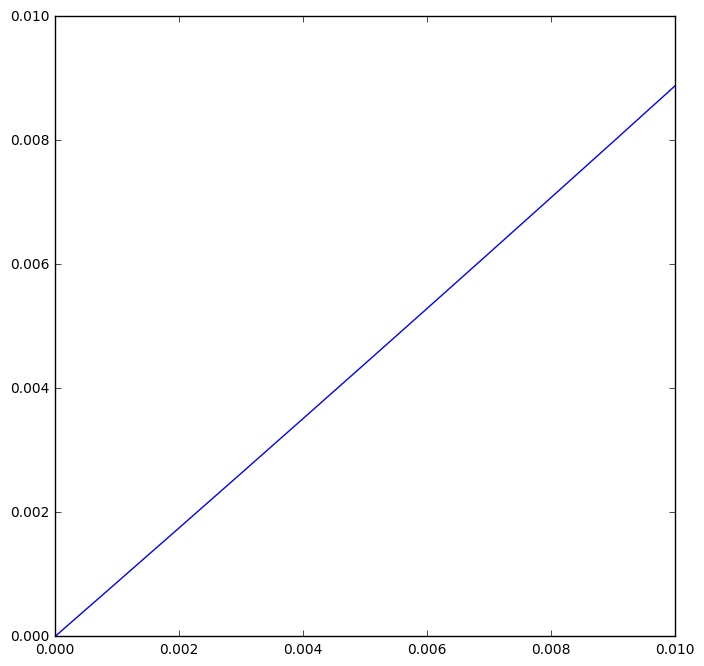

In [55]:
K = 4
params, (b, W, A, d, C) = kspline(x,y,K)

plt.rcParams["figure.figsize"] = (8,8)

xgrid = np.linspace(x[0], x[-1], 1000)

def f_scalar(val):
    for p in range(len(x)-1):
        if x[p] <= val and val <= x[p+1]:
            y = 0
            for k in range(K+1):
                y += params[p*(K+1)+k] * val**(K-k)
            return y
    return float("nan")

def df_scalar(val):
    for p in range(len(x)-1):
        if x[p] <= val and val <= x[p+1]:
            y = 0
            for k in range(K):
                y += (K-k) * params[p*(K+1)+k] * val**(K-k-1)
            return y
    return float("nan")
    

f = np.vectorize(f_scalar)
df = np.vectorize(df_scalar)
                
plt.plot(xgrid, f(xgrid))
#plt.scatter(x, y)
#plt.scatter(1-y, 1-x, color="grey")
plt.xlim(0,0.01)
plt.ylim(0,0.01)
plt.show()


In [1438]:
import math

precomp = dict()
def nCr(n, r):
    if n not in precomp:
        precomp[n] = [None]*(n+1)
    if precomp[n][r] is None:
        value = math.factorial(n) / (math.factorial(r) * math.factorial(n-r))
        precomp[n][r] = value

    return precomp[n][r]

def lorenz_bernstein_scalar(u):
    out = 0
    J = len(x) - 1
    for j in range(J+1):
        out = out + y[j] * nCr(J, j) * u**j * (1-u)**(J-j)
    return out
        
lorenz_bernstein = np.vectorize(lorenz_bernstein_scalar)

lorenz_bernstein(0.5)

array(0.28246949310700176)

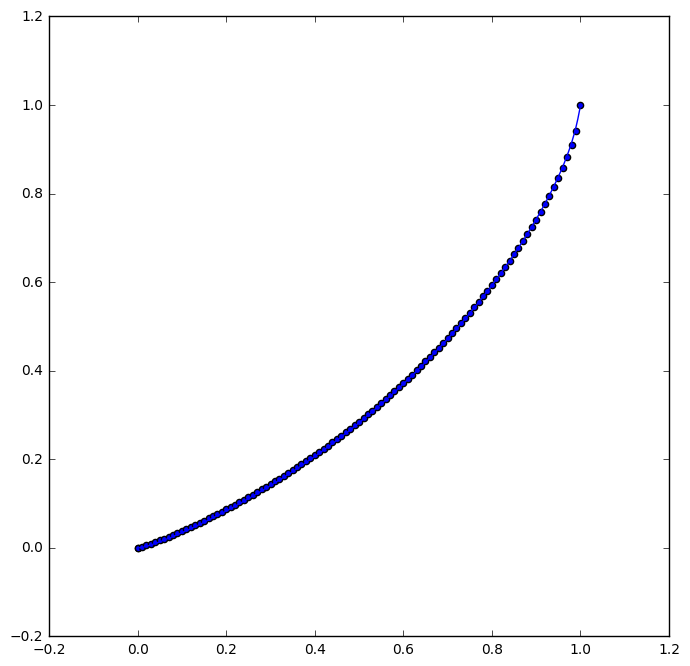

In [1439]:
plt.plot(xgrid, lorenz_bernstein(xgrid))
plt.scatter(x, y)

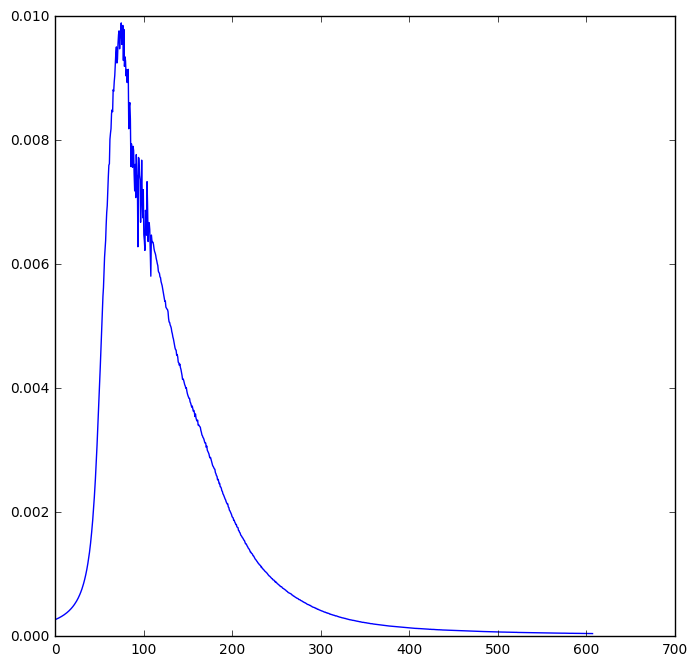

In [1443]:
ygrid3 = np.linspace(0, quantile(0.99), 1000)

quantile_bernstein = lambda p: derivative(lorenz_bernstein)(p) * survey.mean_ppp_month
dist_bernstein = inverse(quantile_bernstein)
dens_bernstein = derivative(dist_bernstein)

plt.plot(ygrid3, dens_bernstein(ygrid3))